# Coefficient Estimation for NEWT

The optimal model involves eight seasonality coefficients and a baseline air temperature sensitivity, a total of nine terms.  We don't need to estimate anything for the relationship between seasonal temperature and sensitivity on a given day, since a global GAM does that.  So we have nine coefficients to estimate.

However, those nine coefficients are correlated, which raises problems for uncertainty analysis and, in general, suggests inefficiency.  So the first thing we're going to do is principle component analysis on the coefficients.

This version of the Notebook implements specialized coefficient estimation for dry/wet years compared to the baseline for each site. We want to predict each coefficient (for a year) in terms of the overall coefficients and the year's mean air temperature and precip, running for water years.

Experiments:

- Whole-year-of, anomaly ~ anomaly only can do 30% for Intercept anomaly, but much worse (<10%) for the rest.
- Previous-year has awful performance for everything.
- Adding both early-year anomalies and baseline coefficients - anomaly ~ (year anom, early year anom, baseline coefs) - gets everything except sensitivity up over 10%, but still nothing reaches 40%. Baseline is usually more important, but early-anom can make a nontrivial contribution. Intercept and WinterDay are in the high 20s to high 30s and sensitivity is at 5, while the rest get 10-15%.
- Timing of "early-year" is highly sensitive. Anomaly nearly doubled in skill when switching from Oct-May to Dec-April.

From experiments to date, it may be worth modeling Intercept, Amplitude, and WinterDay, which all hit the 30%+ range. All are at least a bit nonlinear, especially Amplitude.

In [1]:
import pandas as pd
import pandas.plotting as pdp
import numpy as np
import matplotlib.pyplot as plt
import rtseason as rts
import seaborn as sns
import scipy
import os
from sklearn.decomposition import PCA
import pygam  # https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html
from pygam import LinearGAM, s, te, l, f
from NEWT import Watershed, kfold, perf_summary, statics, analysis, engines
from NEXT.coef_est import build_training_data
import NEXT.data as ndata
import NEWT
import NEXT
from math import ceil
anomweights = np.array([0.132, 0.401, 0.162, 0.119, 0.056, 0.13 ])
bp = "/scratch/dphilippus/notebooks/next_validation/"

ERROR 1: PROJ: proj_create_from_database: Open of /u/wy/ch/dphilippus/.conda/envs/next/share/proj failed


In [ ]:
data = pd.read_csv(bp + "DevDataBuffers.csv", dtype={"id": "str"}, parse_dates=["date"])
data = data[(data["temperature"] > -0.5) & (data["temperature"] < 40)]
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,asp_north,asp_east,lat,lon,year,canopy,flowdir,frozen,cold_prcp,ws_canopy
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.167848,27.182915
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.987468,27.182915
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987895,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,True,0.000000,55.414196
2987896,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196
2987897,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196
2987898,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.004324,0.003170,40.458889,-79.449444,2022,29.154762,12.102172,False,0.000000,55.414196


In [ ]:
data.drop(columns="date").describe()

,temperature,prcp,srad,swe,tmax,tmin,vp,day,water,developed,...,slope,asp_north,asp_east,lat,lon,year,canopy,flowdir,cold_prcp,ws_canopy
count,2.987900e+06,2.987900e+06,2.987900e+06,578400.000000,2.987900e+06,1.433446e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,...,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.987900e+06,2.986986e+06
mean,1.304480e+01,3.425176e+00,3.273382e+02,17.926649,1.688383e+01,5.062516e+00,9.831255e+02,1.872229e+02,1.268352e-02,1.478107e-01,...,1.884932e-03,7.355827e-03,-1.552842e-03,3.992888e+01,-9.565336e+01,2.016161e+03,3.147648e+01,1.888851e+02,1.473491e-01,4.173630e+01
std,7.778464e+00,8.017643e+00,1.310696e+02,49.761395,1.065262e+01,9.425389e+00,6.475989e+02,1.040032e+02,2.060045e-02,2.192455e-01,...,2.532902e-03,1.024769e-02,1.524831e-02,4.613372e+00,1.749465e+01,4.168676e+00,2.808762e+01,9.836393e+01,1.352327e+00,2.300219e+01
min,-4.989583e-01,0.000000e+00,1.599158e+01,0.000000,-2.844553e+01,-3.810106e+01,1.937390e+01,1.000000e+00,0.000000e+00,0.000000e+00,...,4.762368e-05,-1.538242e-02,-2.824883e-01,2.697500e+01,-1.243930e+02,2.004000e+03,0.000000e+00,5.787924e-01,0.000000e+00,4.107644e-02
25%,6.691667e+00,0.000000e+00,2.272068e+02,0.000000,8.669371e+00,-1.216429e+00,5.072167e+02,9.900000e+01,1.829815e-03,1.931167e-02,...,4.481627e-04,3.460877e-03,-2.773193e-03,3.731277e+01,-1.120107e+02,2.013000e+03,4.000000e+00,1.047749e+02,0.000000e+00,2.231672e+01
50%,1.255729e+01,0.000000e+00,3.281181e+02,0.000000,1.786824e+01,5.120216e+00,7.729694e+02,1.890000e+02,5.872330e-03,5.986721e-02,...,9.428893e-04,5.018477e-03,2.168743e-03,4.005460e+01,-8.861419e+01,2.017000e+03,2.404255e+01,1.992379e+02,0.000000e+00,4.210295e+01
75%,1.918229e+01,3.160186e+00,4.291651e+02,7.820107,2.572708e+01,1.199073e+01,1.328157e+03,2.770000e+02,1.551254e-02,1.489284e-01,...,2.337958e-03,8.388438e-03,3.922721e-03,4.325386e+01,-8.047256e+01,2.020000e+03,5.741737e+01,2.747320e+02,0.000000e+00,6.113925e+01
max,3.999688e+01,2.717640e+02,8.285261e+02,750.342160,4.495986e+01,2.819078e+01,3.693103e+03,3.650000e+02,2.316803e-01,9.849686e-01,...,3.008171e-02,2.041745e-01,1.524249e-02,4.899881e+01,-6.780389e+01,2.022000e+03,9.486487e+01,3.586496e+02,8.861503e+01,8.766909e+01


## Prepare Coefficients

In [ ]:
data["year"] = data["date"].dt.year + (data["date"].dt.month > 9) # water year
data

,id,date,temperature,prcp,srad,swe,tmax,tmin,vp,day,...,asp_north,asp_east,lat,lon,year,canopy,flowdir,frozen,cold_prcp,ws_canopy
0,13011820,2020-03-31,0.100000,17.110126,248.76216,NaN,1.795443,NaN,444.26370,91,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
1,13011820,2020-04-01,0.100000,7.202532,403.38873,NaN,0.030759,NaN,270.94354,92,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
2,13011820,2020-04-02,0.100000,2.167848,600.86993,NaN,-3.442405,NaN,132.77936,93,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.167848,27.182915
3,13011820,2020-04-03,0.100000,2.987468,509.44165,NaN,-2.238481,NaN,138.35303,94,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,True,2.987468,27.182915
4,13011820,2020-04-04,0.100000,6.021518,465.97583,NaN,3.509114,NaN,284.43704,95,...,0.003187,0.002841,43.807111,-110.178722,2020,29.173334,260.527706,False,0.000000,27.182915
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2987895,03047000,2022-12-27,0.540625,0.000000,268.23563,NaN,-2.151775,NaN,207.79785,361,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,True,0.000000,55.414196
2987896,03047000,2022-12-28,0.407292,0.000000,279.93356,NaN,5.509683,NaN,310.02664,362,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,False,0.000000,55.414196
2987897,03047000,2022-12-29,0.428125,0.000000,290.53482,NaN,13.100331,NaN,354.31638,363,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,False,0.000000,55.414196
2987898,03047000,2022-12-30,0.661458,0.000000,285.53320,NaN,17.568270,NaN,512.88240,364,...,0.004324,0.003170,40.458889,-79.449444,2023,29.154762,12.102172,False,0.000000,55.414196


In [ ]:
def make_local_coeff(grp, anomilized, yr=None):
    # Make year-specific coefficients using data and a preset year.
    if yr is None:
        if len(grp["day"].unique()) < 181:
            return None
        X = anomilized.loc[:, "delta0":"delta5"]
        y = anomilized["st_anom"]
        prd = X @ anomweights
        ssn = rts.ThreeSine.from_data(grp[["day", "temperature"]]).to_df().drop(columns=["RMSE", "R2"])
        ssn["sensitivity"] = y.abs().mean() / prd.abs().mean()
        return ssn[["Intercept", "Amplitude", "SpringSummer", "FallWinter", "WinterDay", "sensitivity"]]
    grp = grp.loc[grp["year"] == yr]
    anomilized = anomilized.loc[anomilized["year"] == yr]
    # Use existing logic for a single year
    res = make_local_coeff(grp, anomilized, None)
    if res is not None:
        res["year"] = yr
    return res

def make_coefficients(grp, byyr=True):
    if len(grp["day"].unique()) < 181:
        return None
    if len(grp) < 730:
        return None
    anomilized = NEWT.watershed.anomilize(grp).sort_values("date")[["date", "st_anom", "at_anom", "year"]]  # st_anom, at_anom
    for i in range(6):
        anomilized[f"delta{i}"] = anomilized["at_anom"].shift(i)
    anomilized = anomilized.dropna()
    ref = make_local_coeff(grp, anomilized, None)
    if not byyr:
        return ref
    bits = [make_local_coeff(grp, anomilized, year) for year in grp["year"].unique()]
    if all([b is None for b in bits]):
        return None
    yrs = pd.concat(bits)
    res = yrs - ref
    res["year"] = yrs["year"]
    return res.merge(ref.rename(columns=lambda x: x + "_ref"), how="cross").set_index("year")

Change vs baseline notes:

- Intercept: possible range $\pm$6, IQR $\pm$0.4 compared to base IQR of 5. Symmetrical with a small range.
- Amplitude: possible -13 to +6, IQR $\pm$0.4 compared to base IQR 4. Somewhat left-skewed with a small range.
- SpringSummer: possible -12 to +5, IQR -0.2 to +0.7 compared to base IQR 1.3. Nonzero median shift. Lumpy distribution with a large range.
- FallWinter: possible -4 to +6, IQR -0.3 to +0.6 compared to base IQR 1.2. Right-tending distribution with a large range.
- WinterDay: possible $\pm$109, IQR $\pm$10 compared to base IQR 60. Symmetrical with a modest range.
- Sensitivity: possible -0.7 to +1.7, IQR $\pm$0.05 compared to base IQR 0.2. A little right-skewed with a modest range.

In [ ]:
coefs_yr = data.groupby("id").apply(make_coefficients, include_groups=False)#.droplevel(2)
# coefs = data.groupby("id").apply(lambda x: make_coefficients(x, False), include_groups=False).droplevel(1)
coefs_yr.describe()

,Amplitude,FallWinter,Intercept,SpringSummer,WinterDay,sensitivity,Intercept_ref,Amplitude_ref,SpringSummer_ref,FallWinter_ref,WinterDay_ref,sensitivity_ref
count,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000,8234.000000
mean,0.001446,0.137870,0.015602,0.258818,-0.843211,0.003073,12.760922,8.692420,0.752381,1.408417,65.769917,0.585663
std,0.794945,0.758030,0.694818,0.773266,29.164963,0.092506,4.027080,2.815396,0.955484,0.938603,33.184701,0.155609
min,-12.983556,-4.231036,-6.034003,-11.983146,-109.000000,-0.650259,3.085846,0.182583,-2.585014,-2.453322,1.000000,0.072260
25%,-0.411661,-0.292733,-0.389356,-0.212854,-12.000000,-0.047607,9.903103,6.842084,0.038629,0.813096,32.000000,0.486919
50%,-0.001948,0.109838,0.033058,0.204619,0.000000,-0.002717,12.473657,9.121536,0.486446,1.409694,84.000000,0.590550
75%,0.416437,0.571068,0.391465,0.692690,9.000000,0.043899,15.122052,10.853771,1.297292,1.966065,90.000000,0.687392
max,5.991204,6.138540,5.886723,4.883538,109.000000,1.709365,30.100749,15.907383,4.922727,4.801733,110.000000,1.514792


In [ ]:
coefs_yr

Amplitude  FallWinter  Intercept  SpringSummer  \
id              year                                                   
01010000        2013  -0.523222   -0.540827  -0.183049      0.290408   
                2014   0.152114    0.310228  -0.067034      0.199020   
                2015   0.343451    0.203889   0.251004      0.430718   
01011000        2011  -0.398255    0.014615  -0.581494      0.938985   
                2012   0.278617   -0.241342   0.624210     -0.738517   
...                         ...         ...        ...           ...   
453004122510301 2018  -0.138076    1.560369   0.136147      0.323443   
                2019   0.448157   -0.024682   0.147766     -0.200000   
                2020  -0.354094    0.467723   0.074132      0.561227   
                2021   0.575161    0.328937   0.845693     -0.061317   
                2022   0.618139   -0.672863   0.635013      1.965573   

                      WinterDay  sensitivity  Intercept_ref  Amplitude_ref  \
id              year                                                         
01010000        2013        0.0     0.026177       8.227527      11.664508   
                2014       -0.5     0.016199       8.227527      11.664508   
                2015        0.0    -0.079102       8.227527      11.664508   
01011000        2011        0.0     0.114244       8.547659      11.735706   
                2012        0.0    -0.078741       8.547659      11.735706   
...                         ...          ...            ...            ...   
453004122510301 2018      -59.0     0.074364      13.095366       7.200009   
                2019        3.0    -0.071707      13.095366       7.200009   
                2020       25.0     0.114515      13.095366       7.200009   
                2021       22.0     0.072769      13.095366       7.200009   
                2022       -1.0     0.112358      13.095366       7.200009   

                      SpringSummer_ref  FallWinter_ref  WinterDay_ref  \
id              year                                                    
01010000        2013          1.989669        3.269881           27.5   
                2014          1.989669        3.269881           27.5   
                2015          1.989669        3.269881           27.5   
01011000        2011          2.563314        2.746746           27.0   
                2012          2.563314        2.746746           27.0   
...                                ...             ...            ...   
453004122510301 2018          0.377075        1.749345           85.0   
                2019          0.377075        1.749345           85.0   
                2020          0.377075        1.749345           85.0   
                2021          0.377075        1.749345           85.0   
                2022          0.377075        1.749345           85.0   

                      sensitivity_ref  
id              year                   
01010000        2013         0.691518  
                2014         0.691518  
                2015         0.691518  
01011000        2011         0.564576  
                2012         0.564576  
...                               ...  
453004122510301 2018         0.688236  
                2019         0.688236  
                2020         0.688236  
                2021         0.688236  
                2022         0.688236  

[8234 rows x 12 columns]

When seasonality coefficients are near zero, dates are noisy, and we don't want that messing with our model, so we set days to their mean when the corresponding seasonal coefficient is low - "low" being below the 25th percentiles, which are 0.06 C for SpringSummer and 0.8 C for FallWinter.

## Predictors

In [61]:
# Dates correspond loosely to snow season
data["tmax_early"] = data["tmax"] * ((data["date"].dt.month < 5) | (data["date"].dt.month > 11))  # try early-year conditions only
data["prcp_early"] = data["prcp"] * ((data["date"].dt.month < 5) | (data["date"].dt.month > 11))
var = ["tmax", "prcp", "tmax_early", "prcp_early"]
means = data.groupby(["id", "year"])[var].mean()
preds = (means - data.groupby("id")[var].mean()).merge(means, suffixes=["", "_base"], on=["id", "year"])
preds

tmax      prcp  tmax_early  prcp_early  tmax_base  \
id              year                                                           
01010000        2012  11.272355  0.646428    1.027567   -1.157033  20.607761   
                2013   0.237922  0.152035    0.755897    0.011938   9.573327   
                2014  -1.099499 -0.082721   -0.487713    0.198180   8.235906   
                2015  -0.809236 -0.154863   -0.420952   -0.035738   8.526169   
                2016   1.377510 -3.530064    1.027567   -1.157033  10.712915   
...                         ...       ...         ...         ...        ...   
453004122510301 2019   0.032136 -0.390924   -0.039420   -0.274100  17.023711   
                2020   0.104852 -0.756631    0.300701   -0.303105  17.096427   
                2021   1.017177 -0.360030    0.339024   -0.132688  18.008752   
                2022   0.019047  0.353465   -0.067599    0.046042  17.010622   
                2023  -4.703768  1.882911   -2.242514    0.391274  12.287807   

                      prcp_base  tmax_early_base  prcp_early_base  
id              year                                               
01010000        2012   4.176492         0.000000         0.000000  
                2013   3.682099        -0.271669         1.168971  
                2014   3.447343        -1.515280         1.355213  
                2015   3.375201        -1.448519         1.121294  
                2016   0.000000         0.000000         0.000000  
...                         ...              ...              ...  
453004122510301 2019   2.548740         4.377622         1.434322  
                2020   2.183034         4.717743         1.405317  
                2021   2.579635         4.756066         1.575735  
                2022   3.293130         4.349443         1.754464  
                2023   4.822575         2.174528         2.099697  

[9826 rows x 8 columns]

# Model

We'll use a GAM.  This lets us test a broad range of relationships while keeping it quick and interpretable, and has precedent in the literature (PNW from Siegel et al at NOAA Northwestern Fisheries).

## Generalized Code

In [62]:
mdata = pd.concat([coefs_yr, preds], axis=1).dropna()

In [63]:
mdata

Amplitude  FallWinter  Intercept  SpringSummer  \
id              year                                                   
01010000        2013  -0.523222   -0.540827  -0.183049      0.290408   
                2014   0.152114    0.310228  -0.067034      0.199020   
                2015   0.343451    0.203889   0.251004      0.430718   
01011000        2011  -0.398255    0.014615  -0.581494      0.938985   
                2012   0.278617   -0.241342   0.624210     -0.738517   
...                         ...         ...        ...           ...   
453004122510301 2018  -0.138076    1.560369   0.136147      0.323443   
                2019   0.448157   -0.024682   0.147766     -0.200000   
                2020  -0.354094    0.467723   0.074132      0.561227   
                2021   0.575161    0.328937   0.845693     -0.061317   
                2022   0.618139   -0.672863   0.635013      1.965573   

                      WinterDay  sensitivity  Intercept_ref  Amplitude_ref  \
id              year                                                         
01010000        2013        0.0     0.026177       8.227527      11.664508   
                2014       -0.5     0.016199       8.227527      11.664508   
                2015        0.0    -0.079102       8.227527      11.664508   
01011000        2011        0.0     0.114244       8.547659      11.735706   
                2012        0.0    -0.078741       8.547659      11.735706   
...                         ...          ...            ...            ...   
453004122510301 2018      -59.0     0.074364      13.095366       7.200009   
                2019        3.0    -0.071707      13.095366       7.200009   
                2020       25.0     0.114515      13.095366       7.200009   
                2021       22.0     0.072769      13.095366       7.200009   
                2022       -1.0     0.112358      13.095366       7.200009   

                      SpringSummer_ref  FallWinter_ref  WinterDay_ref  \
id              year                                                    
01010000        2013          1.989669        3.269881           27.5   
                2014          1.989669        3.269881           27.5   
                2015          1.989669        3.269881           27.5   
01011000        2011          2.563314        2.746746           27.0   
                2012          2.563314        2.746746           27.0   
...                                ...             ...            ...   
453004122510301 2018          0.377075        1.749345           85.0   
                2019          0.377075        1.749345           85.0   
                2020          0.377075        1.749345           85.0   
                2021          0.377075        1.749345           85.0   
                2022          0.377075        1.749345           85.0   

                      sensitivity_ref      tmax      prcp  tmax_early  \
id              year                                                    
01010000        2013         0.691518  0.237922  0.152035    0.755897   
                2014         0.691518 -1.099499 -0.082721   -0.487713   
                2015         0.691518 -0.809236 -0.154863   -0.420952   
01011000        2011         0.564576 -0.216598  0.768240   -0.047387   
                2012         0.564576  1.611972 -0.356977    0.931984   
...                               ...       ...       ...         ...   
453004122510301 2018         0.688236  0.594291 -0.457221    0.103684   
                2019         0.688236  0.032136 -0.390924   -0.039420   
                2020         0.688236  0.104852 -0.756631    0.300701   
                2021         0.688236  1.017177 -0.360030    0.339024   
                2022         0.688236  0.019047  0.353465   -0.067599   

                      prcp_early  tmax_base  prcp_base  tmax_early_base  \
id              year                                                      
01010000        2013

In [64]:
X = mdata.loc[:, "Intercept_ref":"prcp_early_base"]
allvar = X.columns
allvref = allvar
Y = mdata.loc[:, :"sensitivity"]

In [89]:
# Reference linear model
Xnp = np.concatenate((np.ones((len(X), 1)), X.to_numpy()), axis=1)
lfit = np.linalg.lstsq(Xnp, Y, rcond=None)[0]
prd = Xnp @ lfit
refwt = pd.concat([
    pd.DataFrame({"R2": np.corrcoef(Y.iloc[:, i], prd[:, i])[0, 1]**2}, index=[Y.columns[i]])
    for i in range(len(Y.columns))
])
refwt

,R2
Amplitude,0.097253
FallWinter,0.109820
Intercept,0.323653
SpringSummer,0.061448
WinterDay,0.271117
sensitivity,0.013252


In [131]:
varname = {
    "tmax": "Mean Air Temp Anomaly (C)",
    "prcp": "Mean Precip Anomaly (mm/day)",
    "tmax_early": "Dec-Apr Air Temp Anomaly (C)",
    "prcp_early": "Dec-Apr Precip Anomaly (mm/day)",
    "tmax_base": "Baseline Mean Air Temp (C)",
    "prcp_base": "Baseline Mean Precip (mm/day)",
    "tmax_early_base": "Baseline Dec-Apr Air Temp (C)",
    "prcp_early_base": "Baseline Dec-Apr Precip (mm/day)",
    "Intercept": "3S Intercept Anomaly (C)",
    "Amplitude": "3S Amplitude Anomaly (C)",
    "SpringSummer": "3S Spring/Summer Coef. Anomaly (C)",
    "FallWinter": "3S Autumn/Winter Coef. Anomaly (C)",
    "SpringDay": "3S Spring Date Anomaly (Julian day)",
    "SummerDay": "3S Summer Date Anomaly (Julian day)",
    "FallDay": "3S Autumn Date Anomaly (Julian day)",
    "WinterDay": "3S Winter Date Anomaly (Julian day)",
    "sensitivity": "Air Temp. Anomaly Sensitivity Anomaly (C/C)",
    "Intercept_ref": "Baseline 3S Intercept (C)",
    "Amplitude_ref": "Baseline 3S Amplitude (C)",
    "SpringSummer_ref": "Baseline 3S Spring/Summer Coef. (C)",
    "FallWinter_ref": "Baseline 3S Autumn/Winter Coef. (C)",
    "WinterDay_ref": "Baseline 3S Winter Date (Julian day)",
    "sensitivity_ref": "Baseline Air Temp. Anomaly Sensitivity (C/C)"
}
rename = lambda vrs: [varname[v] for v in vrs]

After PCA, the best-variable linear performance is much worse, at 0.59.  We'll see how the GAM does.

With the rescaled round 1 (dates scaled only), best-variable fit is 0.87, with 0.56 for the next and declining from there.

### The Actual Code

In [25]:
def pdps(gam, xy0=True, names=None, ylab=None, save=None):
    nt = len(gam.terms) - 1
    Ny = 1 if nt < 3 else (2 if nt < 9 else 3)
    Nx = nt // Ny + (1 if nt % Ny > 0 else 0)
    _, axes = plt.subplots(Ny, Nx, figsize=(12,8), layout="compressed")
    for i, term in enumerate(gam.terms):
        if term.isintercept:
            continue
        ax = axes[i // Nx, i % Nx] if Ny > 1 else axes[i]
        if term.istensor:
            XX = gam.generate_X_grid(term=i, meshgrid=True)
            Z = gam.partial_dependence(term=i, X=XX, meshgrid=True)
            co = ax.contourf(XX[1], XX[0], Z)
            ax.set_xlabel(repr(term) if names is None else names[term.info["terms"][1]["feature"]])
            ax.set_ylabel(repr(term) if names is None else names[term.info["terms"][0]["feature"]])
            
        else:
            XX = gam.generate_X_grid(term=i)
            pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)
    
            ax.plot(XX[:, term.feature], pdep)
            ax.plot(XX[:, term.feature], confi, c='r', ls='--')
            if ylab is not None and i % Nx == 0:
                ax.set_ylabel(ylab)
            ax.set_xlabel(repr(term) if names is None else names[i])
    if save is not None:
        plt.savefig(bp + save)

def get_pd(gam, n):
    XX = gam.generate_X_grid(term=n)
    y = gam.partial_dependence(term=n, X=XX)
    return (XX[:,n], y)

In [66]:
eqmk = lambda N: sum([s(i) for i in range(1, N)], start=s(0))
var = X.columns
print(len(var))

14


## Intercept

Linear anomaly-only: R2 0.20

GAM anomaly-only: R2 ~0.30

G-ao previous year: ~0.03

G-ao add early temp anom: ~0.36

G-baseline: 0.32

G-bl-early: 0.39 (AIC: 22700)

G-bl-early-bl: 0.42 (AIC: 23200)

Everything, snow/melt seasons: 0.35 (AIC: 22000)

Everything, snow season: 0.44 (23700)

In [134]:
yv = "Intercept"
xv_itx = ['tmax', 'tmax_early']
gam = LinearGAM(eqmk(len(xv_itx)), lam=10).fit(X[xv_itx], Y[yv])
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     16.2987
Link Function:                     IdentityLink Log Likelihood:                                -11274.3774
Number of Samples:                         8234 AIC:                                            22583.3523
                                                AICc:                                           22583.4293
                                                GCV:                                                0.3053
                                                Scale:                                              0.3042
                                                Pseudo R-Squared:                                    0.371
Feature Function                  Lam

/tmp/ipykernel_160452/1209197729.py:4: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


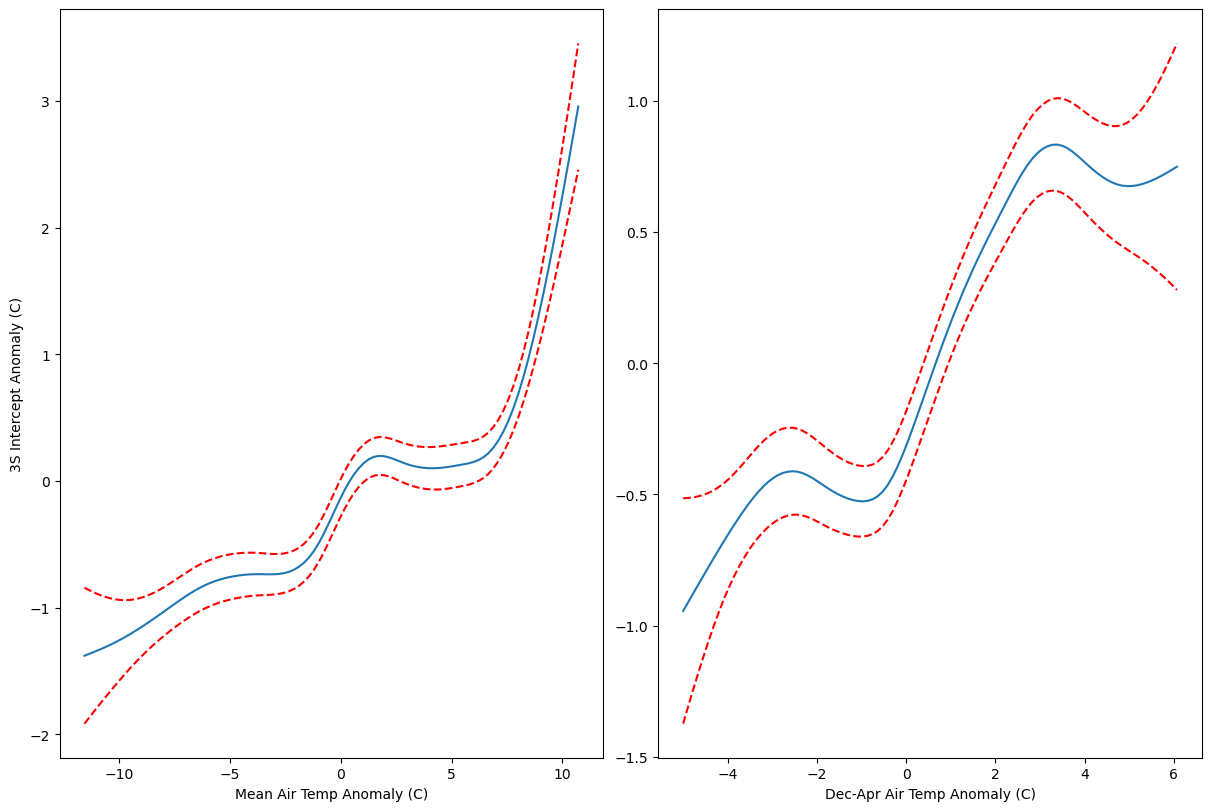

In [135]:
pdps(gam, False, rename(xv), rename([yv])[0])

## Amplitude

Linear anomaly-only: R2 ~0

GAM anomaly-only: ~0.05

G-ao-py: 0.02

G-ao w/early: 0.08

G-bl: 0.09

G-bl-early: 0.13 (AIC: 20300)

G-bl-early-bl: 0.18 (AIC: 20200)

E,s/m: 0.15 (20300)

E,s: 0.26 (20200)

In [147]:
yv = "Amplitude"
xv_amp = ['Intercept_ref', 'FallWinter_ref',
       'tmax', 'prcp', 'tmax_early',
       'prcp_early', 'tmax_base', 'tmax_early_base']
gam = LinearGAM(eqmk(len(xv_amp)), lam=10).fit(X[xv_amp], Y[yv])
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     70.0241
Link Function:                     IdentityLink Log Likelihood:                                -10022.9422
Number of Samples:                         8234 AIC:                                            20187.9325
                                                AICc:                                            20189.186
                                                GCV:                                                0.5059
                                                Scale:                                              0.4982
                                                Pseudo R-Squared:                                   0.2182
Feature Function                  Lam

/tmp/ipykernel_160452/3713366358.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


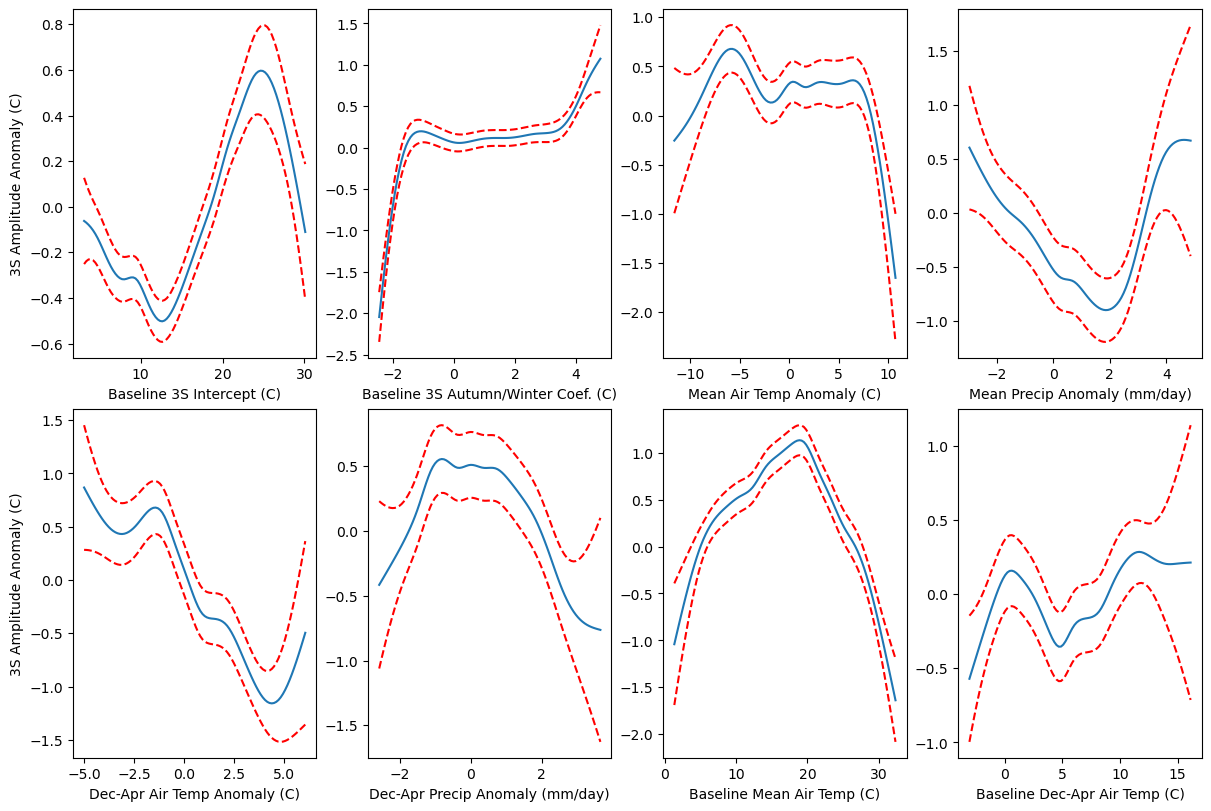

In [148]:
pdps(gam, False, rename(xv_amp), rename([yv])[0])

## SpringSummer

Linear anomaly-only: R2 ~0

GAM anomaly-only: R2 ~0.04

G-ao-py: 0.02

G-ao w/early: 0.08

G-bl: 0.08

G-bl-early: 0.12 (AIC: 20200)

G-bl-early-bl: 0.14 (AIC: 20200)

E,s/m: 0.11 (20300)

E,s: 0.12 (20200)

In [72]:
yv = "SpringSummer"
gam = LinearGAM(eqmk(14), lam=10).fit(X, Y[yv])
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    126.5084
Link Function:                     IdentityLink Log Likelihood:                                 -9991.5542
Number of Samples:                         8234 AIC:                                            20238.1252
                                                AICc:                                           20242.1684
                                                GCV:                                                0.5487
                                                Scale:                                              0.5335
                                                Pseudo R-Squared:                                   0.1214
Feature Function                  Lam

/tmp/ipykernel_160452/488752957.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


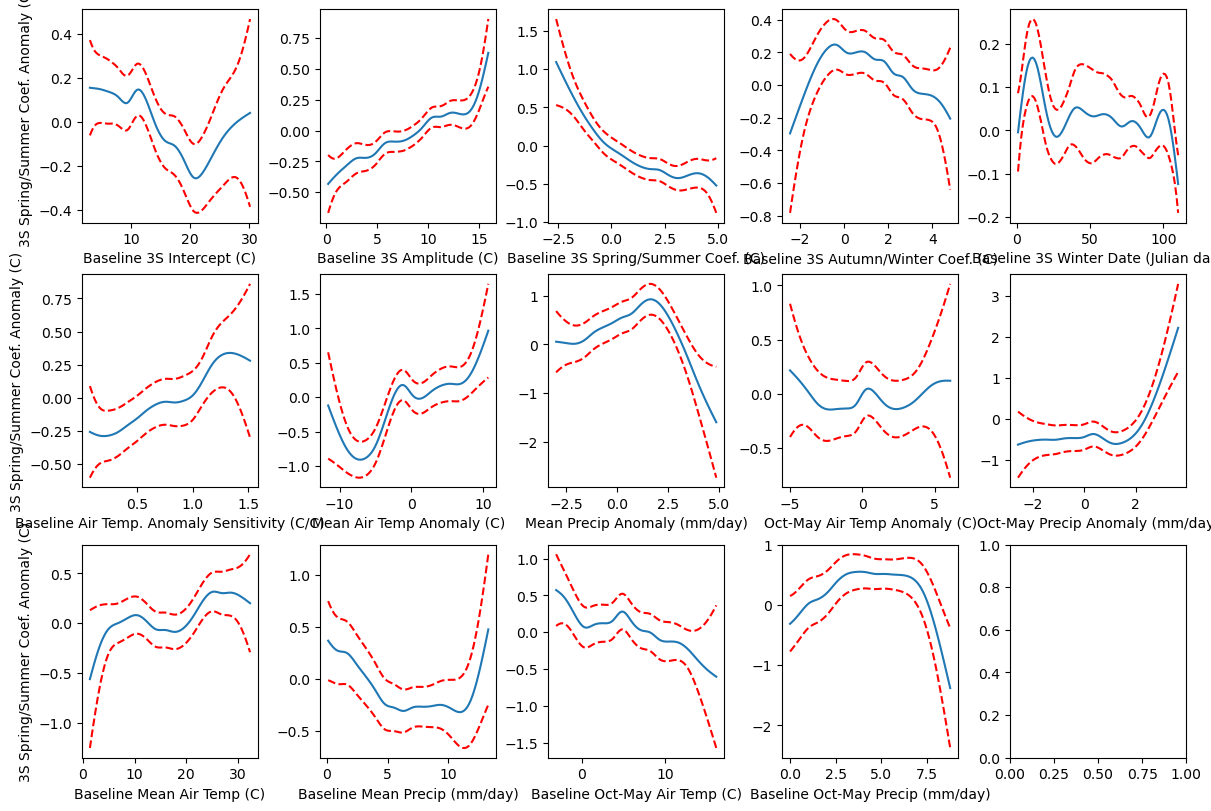

In [73]:
pdps(gam, False, rename(var), rename([yv])[0])

## FallWinter

Linear anomaly-only: R2 ~0

GAM anomaly-only: ~0.06

G-ao-py: 0.01

G-ao w/early: 0.08

G-bl: 0.13

G-bl-early: 0.15 (AIC: 20200)

G-bl-early-bl: 0.19 (AIC: 20200)

E,s/m: 0.17 (20200)

E,s/m: 0.19 (20200)

In [74]:
yv = "FallWinter"
gam = LinearGAM(eqmk(14), lam=10).fit(X, Y[yv])
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    126.5084
Link Function:                     IdentityLink Log Likelihood:                                  -9974.382
Number of Samples:                         8234 AIC:                                            20203.7807
                                                AICc:                                           20207.8239
                                                GCV:                                                0.4837
                                                Scale:                                              0.4704
                                                Pseudo R-Squared:                                   0.1939
Feature Function                  Lam

/tmp/ipykernel_160452/2085851708.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


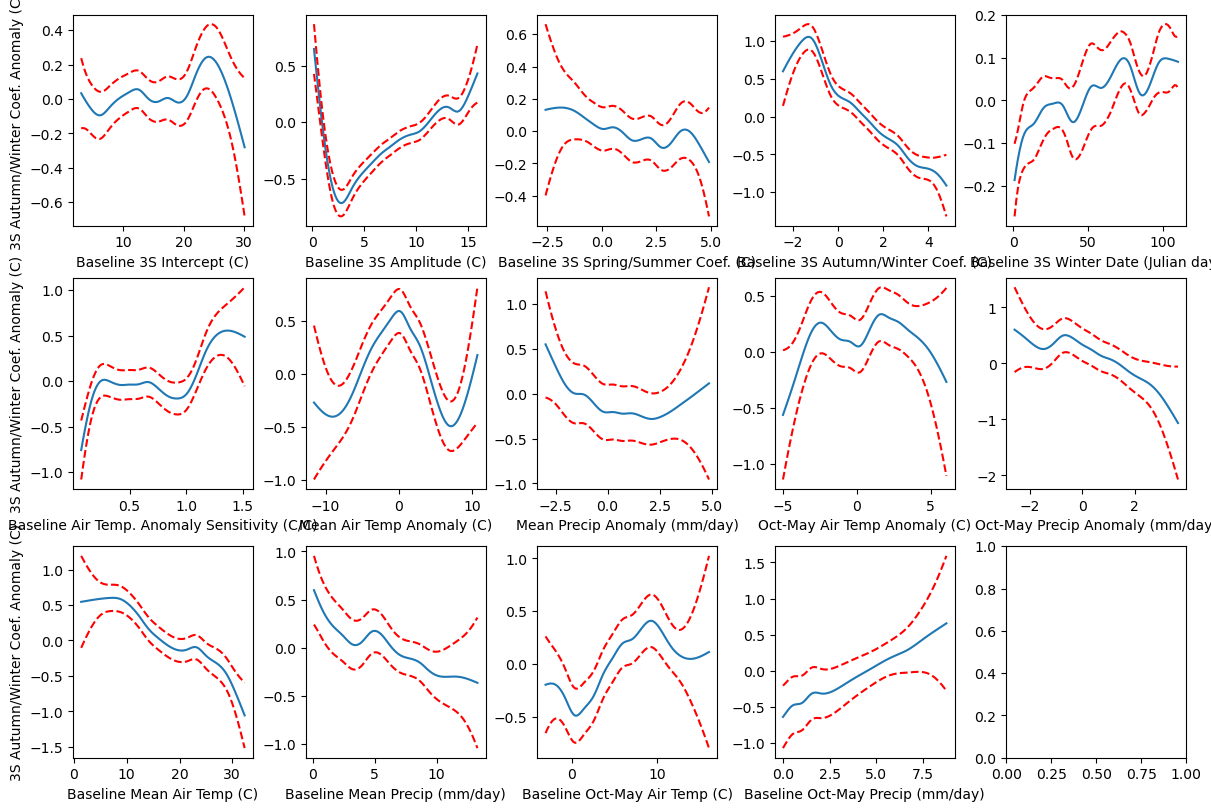

In [75]:
pdps(gam, False, rename(var), rename([yv])[0])

## WinterDay

Linear anomaly-only: R2 ~0

GAM anomaly-only: R2 ~0.03

G-ao w/early: 0.05

G-bl: 0.28

G-bl-early: 0.29 (AIC: 121000)

G-b-e-b: 0.33 (AIC: 120000)

E,s/m: 0.32 (AIC: 120000)

E,s: 0.34 (120000)

In [164]:
yv = "WinterDay"
xv_wid = ['Intercept_ref', 'Amplitude_ref',
       'WinterDay_ref', 'tmax_early', 'tmax_base']
gam = LinearGAM(eqmk(len(xv_wid)), lam=10).fit(X[xv_wid], Y[yv])
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     49.8463
Link Function:                     IdentityLink Log Likelihood:                                 -60608.943
Number of Samples:                         8234 AIC:                                           121319.5786
                                                AICc:                                           121320.223
                                                GCV:                                              633.9902
                                                Scale:                                            627.0856
                                                Pseudo R-Squared:                                   0.2671
Feature Function                  Lam

/tmp/ipykernel_160452/3419220596.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


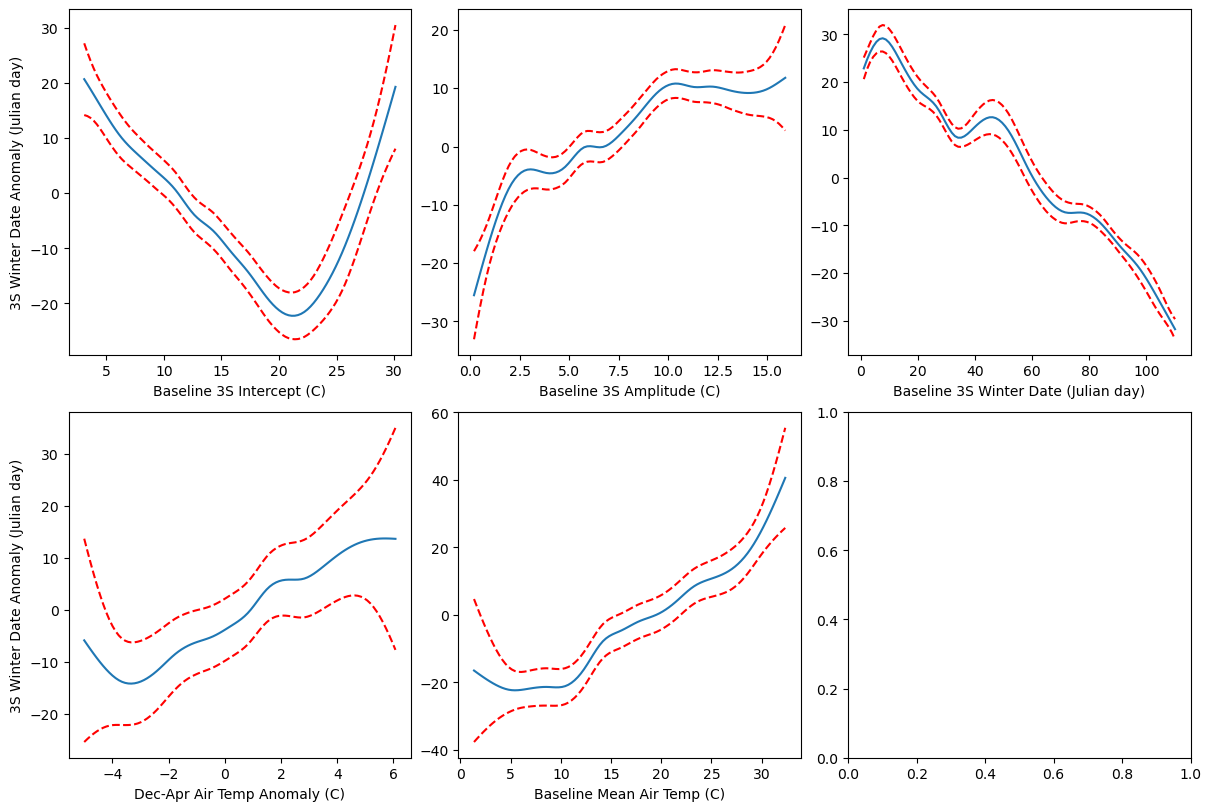

In [165]:
pdps(gam, False, rename(xv_wid), rename([yv])[0])

## Sensitivity

Linear anom-only: R2 ~0

GAM anom-only: R2 ~0.03

G-ao w/early: 0.04

G-bl: 0.03

G-bl-early: 0.05 (AIC: 923000)

G-b-e-b: 0.06 (AIC: 924000)

E,s/m: 0.05 (919000)

E,s: 0.05 (919000)

In [78]:
yv = "sensitivity"
gam = LinearGAM(eqmk(14), lam=10).fit(X, Y[yv])
gam.summary()

LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    126.5084
Link Function:                     IdentityLink Log Likelihood:                               -459151.6078
Number of Samples:                         8234 AIC:                                           918558.2323
                                                AICc:                                          918562.2754
                                                GCV:                                                0.0085
                                                Scale:                                              0.0083
                                                Pseudo R-Squared:                                   0.0501
Feature Function                  Lam

/tmp/ipykernel_160452/1858203613.py:3: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  gam.summary()


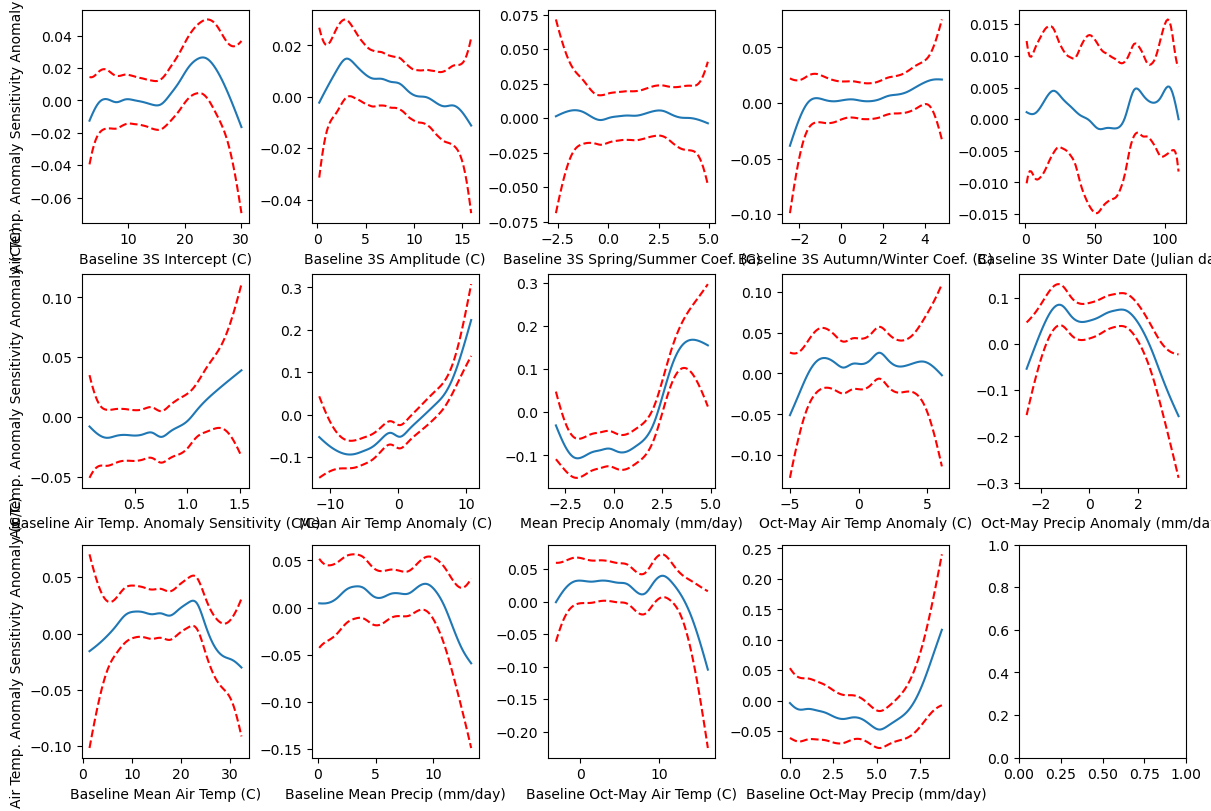

In [79]:
pdps(gam, False, rename(var), rename([yv])[0])

# Print GAMs

In [170]:
# Run this to build list...
print("month_range = [12, 1, 2, 3, 4]")
print("var_sets = {")
print(f'\t"Intercept": {xv_itx},')
print(f'\t"Amplitude": {xv_amp},')
print(f'\t"WinterDay": {xv_wid}')
print("}")

month_range = [12, 1, 2, 3, 4]
var_sets = {
	"Intercept": ['tmax', 'tmax_early'],
	"Amplitude": ['Intercept_ref', 'FallWinter_ref', 'tmax', 'prcp', 'tmax_early', 'prcp_early', 'tmax_base', 'tmax_early_base'],
	"WinterDay": ['Intercept_ref', 'Amplitude_ref', 'WinterDay_ref', 'tmax_early', 'tmax_base']
}


# Cross-Validation Test

Right, we've got some approaches laid out.  Let's test it!  Export the GAM setups and hop over to the validation notebook.

Oddly, the "smart GAMs" are doing slightly worse than the "naive GAMs", though global R2 is much better.  Mainly, RMSE is marginally higher (2.3 vs 2.2 C median).  The plots show the usual mix of some near-perfect fits and some wildly off, with everything in between.

One possibility is that the relatively high lambdas, or likewise the aggressive paring-down, hinder cross-validation performance.  Performance characteristics shown suggest that the amplitude terms or the weather sensitivity may be faring poorly.  It's also possible that the intercept-normalizing of the amplitude coefficients was a net negative.

Allowing more flexibility helped but did not fully address the problem.  Likewise for non-normalizing.

I do wonder if the threshold behavior might be hurting rather than helping, since it seems rather hard to predict threshold coefficients.  The last resort would be that we really need the point-area data.

Excluding thresholds makes performance worse, though it does make the model ~3x faster.  The other last resort is to see what happens if we do include elevation.

Or, I may have been too aggressive about excluding covariates.

- Initial test: R2 0.94 (global 0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.8% (2.0%) = 0.34 (0.26) C, max miss 3.0 (14.1) C
- More flexible: R2 0.94 (0.86), RMSE 2.3 (2.9) C, NSE 0.88 (0.86), bias 2.1% (2.0%) = 0.27 (0.27) C, max miss 2.9 (12.3) C
- Non-normalized: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88, bias 2.5% (1.9%) = 0.35 (0.25) C, max miss 3.0 (12.2) C
- No threshold: R2 0.94 (0.87), RMSE 2.3 (2.8) C, NSE 0.88 (0.87), bias 2.6% (2.0%) = 0.35 (0.26) C, max miss 3.3 (12.3) C
- Smarter GAMs (with threshold): R2 0.94 (0.88), RMSE 2.1 (2.7) C, NSE 0.90 (0.88), bias 2.2% (2.0%) = 0.29 (0.26) C, max miss 3.0 (9.3) C

Now we're talking!  And the major problem does seem to be anomaly prediction, but this version is good enough for now.

The anomaly NSE is actually surprisingly good, at 0.50 (better than TE2, oddly), but, oddly, that's worse than stationary ("same as yesterday").  In TempEst 2, stationary NSE was ~0.2.  Not sure what happened there.  Though, of course, for ungaged watersheds we don't *have* an observation for yesterday, so it's still an improvement and considerably better than climatology (NSE = 0).